In [ ]:
`!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vanamasainadh90","key":"af9782a3c17afbac91b324b6b14864bc"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mahmoudima/mma-facial-expression


Dataset URL: https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression
License(s): unknown
 93% 154M/166M [00:01<00:00, 125MB/s]
100% 166M/166M [00:01<00:00, 105MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("mma-facial-expression.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/mma_facial_expression")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)



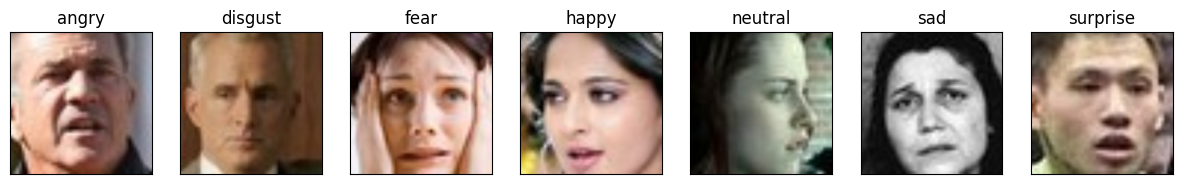

In [ ]:
import matplotlib.pyplot as plt

class_names = train_emotion.classes

fig = plt.figure(figsize=(15, 5))
num_classes = len(class_names)
for i in range(num_classes):
    ax = fig.add_subplot(1, num_classes, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img, label = next((img, label) for img, label in test_emotion if label == i)
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
plt.show()


In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4630, 0.4530, 0.3405], std = [0.2862, 0.2758, 0.2845])
])

In [ ]:
train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)


In [ ]:
from collections import Counter

train_class_counts = Counter([label for _, label in train_emotion.samples])
print("Number of images in each class (Train):")
for class_idx, count in train_class_counts.items():
    print(f"{class_names[class_idx]}: {count}")

test_class_counts = Counter([label for _, label in test_emotion.samples])
print("\nNumber of images in each class (Test):")
for class_idx, count in test_class_counts.items():
    print(f"{class_names[class_idx]}: {count}")

Number of images in each class (Train):
angry: 6566
disgust: 3231
fear: 4859
happy: 28592
neutral: 29384
sad: 12223
surprise: 8113

Number of images in each class (Test):
angry: 1041
disgust: 655
fear: 691
happy: 5459
neutral: 5858
sad: 2177
surprise: 1475


In [ ]:
from PIL import Image, UnidentifiedImageError

for img_path, _ in train_emotion.samples:
    try:
        with Image.open(img_path) as img:
            img.verify()
    except UnidentifiedImageError:
        print(f"Corrupt image: {img_path}")


In [ ]:
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch

class_counts = Counter(train_emotion.targets)
class_weights = [1.0 / class_counts[i] for i in range(len(train_emotion.classes))]
sample_weights = [class_weights[label] for _, label in train_emotion.samples]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_emotion, batch_size=32, sampler=sampler)


Class distribution after sampling:
surprise: 13173 samples
sad: 13319 samples
fear: 13318 samples
happy: 13317 samples
neutral: 13153 samples
angry: 13298 samples
disgust: 13390 samples


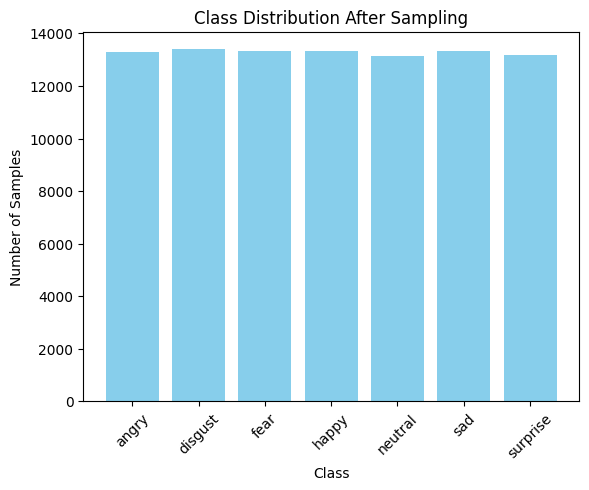

In [ ]:
from collections import Counter

sampled_indices = list(sampler)
sampled_labels = [train_emotion.targets[idx] for idx in sampled_indices]

sampled_class_counts = Counter(sampled_labels)
print("Class distribution after sampling:")
for class_idx, count in sampled_class_counts.items():
    print(f"{train_emotion.classes[class_idx]}: {count} samples")
import matplotlib.pyplot as plt

classes = [train_emotion.classes[idx] for idx in range(len(train_emotion.classes))]
class_sizes = [sampled_class_counts.get(idx, 0) for idx in range(len(train_emotion.classes))]

plt.bar(classes, class_sizes, color='skyblue')
plt.title("Class Distribution After Sampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])


train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)

train_loader_emotion = DataLoader(train_emotion, batch_size=128, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=128, shuffle=False)

class_names = train_emotion.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
def test(model, train_loader, test_loader):
    model.eval()
    predict_train = []
    predict_test = []
    labels_train = []
    labels_test = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())
    print("Confusion matrix on train:\n",
          confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names))))
    print("\nClassification report on train:\n",
          classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names)), target_names=class_names))
    print("\nConfusion matrix on test:\n",
          confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names))))
    print("\nClassification report on test:\n",
          classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names)), target_names=class_names))



In [ ]:
torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer_adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=5,
    optimizer=optimizer_adam,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion
)

test(model, train_loader_emotion, test_loader_emotion)

Epoch 0, Training loss 1.5167879876277142
Epoch 1, Training loss 1.4042847448398847
Epoch 2, Training loss 1.3276068454267562
Epoch 3, Training loss 1.2844326624024194
Epoch 4, Training loss 1.257581303995282
Confusion matrix on train:
 [[  735     0   555   853  3031   764   628]
 [   74     0    83   421  2304   183   166]
 [  250     0  1113   438  1556   586   916]
 [  212     0   351 19339  7217   890   583]
 [  221     0   391  2493 24293  1162   824]
 [  216     0   602  1424  7140  2327   514]
 [   80     0   408   719  2809   285  3812]]

Classification report on train:
               precision    recall  f1-score   support

       angry       0.41      0.11      0.18      6566
     disgust       0.00      0.00      0.00      3231
        fear       0.32      0.23      0.27      4859
       happy       0.75      0.68      0.71     28592
     neutral       0.50      0.83      0.63     29384
         sad       0.38      0.19      0.25     12223
    surprise       0.51      0.47 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

#Random Search

In [ ]:
import random

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_filters = [8, 16, 32, 64]
kernel_sizes = [3, 5]
stride_values = [1, 2]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 4
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    filters = random.choice(num_filters)
    kernel_size = random.choice(kernel_sizes)
    stride = random.choice(stride_values)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                x = self.activation(self.conv3(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, 10)

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    elif layers == 2:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, 10)

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    else:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, 10)

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    train_loader_emotion = torch.utils.data.DataLoader(train_emotion, batch_size=batch_size, shuffle=True)
    test_loader_emotion = torch.utils.data.DataLoader(test_emotion, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    model = CNN(filters, kernel_size, stride, activation_fn)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}/{n_iterations}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Filters: {filters}, Kernel Size: {kernel_size}, Activation Function: {activation_fn}")

    training_loop(n_epochs=5, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader_emotion)

    print("Testing the model...")
    test_results = test(model, train_loader_emotion, test_loader_emotion)

    accuracy = confusion_matrix(list(chain(*test_results["labels"])), list(chain(*test_results["predictions"]))).trace()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            "Batch Size": batch_size,
            "Learning Rate": learning_rate,
            "Layers": layers,
            "Filters": filters,
            "Kernel Size": kernel_size,
            "Activation Function": activation_fn,
            "Optimizer": optimizer_name
        }

print("\nBest Hyperparameters:", best_params)



Iteration 1/4
Optimizer: SGD
Batch Size: 64, Learning Rate: 0.01, Layers: 1, Filters: 64, Kernel Size: 5, Activation Function: Sigmoid()
Epoch 0, Training loss 2.1725089805994213


KeyboardInterrupt: 

# failed excexution due to large data

full data set run through. So, we used subset sampling to fasten up the process

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)
class_names = train_emotion.classes

subset_percentage = 0.02 # used 20% of data
subset_size = int(len(train_emotion) * subset_percentage)
subset_indices = random.sample(range(len(train_emotion)), subset_size)
train_emotion_subset = Subset(train_emotion, subset_indices)

batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_filters = [8, 16, 32, 64]
kernel_sizes = [3, 5]
stride_values = [1, 2]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 4
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    filters = random.choice(num_filters)
    kernel_size = random.choice(kernel_sizes)
    stride = random.choice(stride_values)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                x = self.activation(self.conv3(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    elif layers == 2:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    else:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)

                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))

                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    train_loader_subset = DataLoader(train_emotion_subset, batch_size=batch_size, shuffle=True)
    test_loader_emotion = DataLoader(test_emotion, batch_size=batch_size, shuffle=False)

    torch.manual_seed(0)
    model = CNN(filters, kernel_size, stride, activation_fn)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}/{n_iterations}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Filters: {filters}, Kernel Size: {kernel_size}, Activation Function: {activation_fn}")

    for epoch in range(5):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader_subset:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}: Training Loss: {train_loss/len(train_loader_subset):.4f}")

    print("Testing the model...")
    predict_test = []
    labels_test = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader_emotion:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predict_test.extend(predicted.tolist())
            labels_test.extend(labels.tolist())

    accuracy = sum(1 for x, y in zip(predict_test, labels_test) if x == y) / len(labels_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            "Batch Size": batch_size,
            "Learning Rate": learning_rate,
            "Layers": layers,
            "Filters": filters,
            "Kernel Size": kernel_size,
            "Activation Function": activation_fn,
            "Optimizer": optimizer_name
        }

print("\nBest Hyperparameters:", best_params)



Iteration 1/4
Optimizer: RMSprop
Batch Size: 128, Learning Rate: 0.01, Layers: 1, Filters: 8, Kernel Size: 3, Activation Function: Sigmoid()
Epoch 1: Training Loss: 1.7955
Epoch 2: Training Loss: 1.7546
Epoch 3: Training Loss: 1.7406
Epoch 4: Training Loss: 1.7357
Epoch 5: Training Loss: 1.7271
Testing the model...

Iteration 2/4
Optimizer: SGD
Batch Size: 32, Learning Rate: 0.0001, Layers: 3, Filters: 16, Kernel Size: 3, Activation Function: Tanh()
Epoch 1: Training Loss: 1.9601
Epoch 2: Training Loss: 1.9591
Epoch 3: Training Loss: 1.9571
Epoch 4: Training Loss: 1.9558
Epoch 5: Training Loss: 1.9556
Testing the model...

Iteration 3/4
Optimizer: RMSprop
Batch Size: 64, Learning Rate: 0.0001, Layers: 1, Filters: 16, Kernel Size: 3, Activation Function: Tanh()
Epoch 1: Training Loss: 1.9595
Epoch 2: Training Loss: 1.9457
Epoch 3: Training Loss: 1.9326
Epoch 4: Training Loss: 1.9244
Epoch 5: Training Loss: 1.9087
Testing the model...

Iteration 4/4
Optimizer: Adam
Batch Size: 64, Learn

### Running random search for second time

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report

emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])


train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)
class_names = train_emotion.classes


subset_percentage = 0.1
subset_size = int(len(train_emotion) * subset_percentage)
subset_indices = random.sample(range(len(train_emotion)), subset_size)
train_emotion_subset = Subset(train_emotion, subset_indices)


batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_filters = [8, 16, 32, 64]
kernel_sizes = [3, 5]
stride_values = [1, 2]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 4
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    filters = random.choice(num_filters)
    kernel_size = random.choice(kernel_sizes)
    stride = random.choice(stride_values)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)
    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                x = self.activation(self.conv3(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    elif layers == 2:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    else:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    train_loader_subset = DataLoader(train_emotion_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_emotion, batch_size=batch_size, shuffle=False)

    model = CNN(filters, kernel_size, stride, activation_fn)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}/{n_iterations}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Filters: {filters}, Kernel Size: {kernel_size}, Activation Function: {activation_fn}")

    model.train()
    for epoch in range(5):
        train_loss = 0.0
        for inputs, labels in train_loader_subset:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}: Training Loss: {train_loss / len(train_loader_subset):.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            "Batch Size": batch_size,
            "Learning Rate": learning_rate,
            "Layers": layers,
            "Filters": filters,
            "Kernel Size": kernel_size,
            "Activation Function": activation_fn,
            "Optimizer": optimizer_name
        }

print("\nBest Hyperparameters:", best_params)



Iteration 1/4
Optimizer: Adam
Batch Size: 16, Learning Rate: 0.001, Layers: 3, Filters: 8, Kernel Size: 3, Activation Function: Tanh()
Epoch 1: Training Loss: 1.6478
Epoch 2: Training Loss: 1.6180
Epoch 3: Training Loss: 1.6091
Epoch 4: Training Loss: 1.6014
Epoch 5: Training Loss: 1.5982

Confusion Matrix:
[[   6    0   24  509  480    6   16]
 [   0    0    9  282  361    1    2]
 [   4    0   37  319  301   14   16]
 [   6    0   26 2463 2923   19   22]
 [   4    0   21 2201 3591   14   27]
 [   6    0   14  971 1152   16   18]
 [   1    0   45  706  686    5   32]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.22      0.01      0.01      1041
     disgust       0.00      0.00      0.00       655
        fear       0.21      0.05      0.09       691
       happy       0.33      0.45      0.38      5459
     neutral       0.38      0.61      0.47      5858
         sad       0.21      0.01      0.01      2177
    surprise       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Training Loss: 1.7669
Epoch 2: Training Loss: 1.6670
Epoch 3: Training Loss: 1.6469
Epoch 4: Training Loss: 1.6371
Epoch 5: Training Loss: 1.6315

Confusion Matrix:
[[   0    0    0  497  541    3    0]
 [   2    0    0  285  367    0    1]
 [   4    0    1  363  320    3    0]
 [   4    3    4 2309 3125   13    1]
 [   5    4    5 2298 3539    7    0]
 [   2    2    2  942 1226    3    0]
 [   5    1    1  720  745    3    0]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1041
     disgust       0.00      0.00      0.00       655
        fear       0.08      0.00      0.00       691
       happy       0.31      0.42      0.36      5459
     neutral       0.36      0.60      0.45      5858
         sad       0.09      0.00      0.00      2177
    surprise       0.00      0.00      0.00      1475

    accuracy                           0.34     17356
   macro avg       0.12      0.15      0.12    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Training Loss: 1.8315
Epoch 2: Training Loss: 1.7691
Epoch 3: Training Loss: 1.7414
Epoch 4: Training Loss: 1.7238
Epoch 5: Training Loss: 1.7113

Confusion Matrix:
[[  13    0    0  797  231    0    0]
 [   0    0    0  455  200    0    0]
 [   4    0    0  542  145    0    0]
 [  23    0    0 3732 1704    0    0]
 [  32    0    0 3680 2146    0    0]
 [   8    0    0 1458  711    0    0]
 [   2    0    0 1061  412    0    0]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.16      0.01      0.02      1041
     disgust       0.00      0.00      0.00       655
        fear       0.00      0.00      0.00       691
       happy       0.32      0.68      0.43      5459
     neutral       0.39      0.37      0.38      5858
         sad       0.00      0.00      0.00      2177
    surprise       0.00      0.00      0.00      1475

    accuracy                           0.34     17356
   macro avg       0.12      0.15      0.12    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 3Rd random search

In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

# Load datasets
train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)
class_names = train_emotion.classes

# Subset Sampling
subset_percentage = 0.05
subset_size = int(len(train_emotion) * subset_percentage)
subset_indices = random.sample(range(len(train_emotion)), subset_size)
train_emotion_subset = Subset(train_emotion, subset_indices)

# Hyperparameter space
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
num_filters = [8, 16, 32, 64]
kernel_sizes = [3, 5]
stride_values = [1, 2]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 10
best_accuracy = 0
best_params = {}

for i in range(n_iterations):
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    filters = random.choice(num_filters)
    kernel_size = random.choice(kernel_sizes)
    stride = random.choice(stride_values)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)
    optimizer_name, optimizer_class = random.choice(optimizers)

    if layers == 3:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                x = self.activation(self.conv3(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    elif layers == 2:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                x = self.activation(self.conv2(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    else:
        class CNN(nn.Module):
            def __init__(self, filters, kernel_size, stride, activation_fn):
                super().__init__()
                self.conv1 = nn.Conv2d(3, filters, kernel_size=kernel_size, stride=stride, padding=1)
                self.pool = nn.MaxPool2d(2)
                self.activation = activation_fn
                self.fc = None
                self.flatten_size = None

            def forward(self, x):
                x = self.activation(self.conv1(x))
                x = self.pool(x)
                if self.flatten_size is None:
                    self.flatten_size = x.numel() // x.size(0)
                    self.fc = nn.Linear(self.flatten_size, len(class_names))
                x = x.view(x.size(0), -1)
                x = self.fc(x)
                return x

    # Load subset data with selected batch size
    train_loader_subset = DataLoader(train_emotion_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_emotion, batch_size=batch_size, shuffle=False)

    # Define model, optimizer, and loss function
    model = CNN(filters, kernel_size, stride, activation_fn)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\nIteration {i+1}/{n_iterations}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Filters: {filters}, Kernel Size: {kernel_size}, Activation Function: {activation_fn}")

    model.train()
    for epoch in range(5):
        train_loss = 0.0
        for inputs, labels in train_loader_subset:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}: Training Loss: {train_loss / len(train_loader_subset):.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            "Batch Size": batch_size,
            "Learning Rate": learning_rate,
            "Layers": layers,
            "Filters": filters,
            "Kernel Size": kernel_size,
            "Activation Function": activation_fn,
            "Optimizer": optimizer_name
        }

print("\nBest Hyperparameters:", best_params)


Iteration 1/10
Optimizer: SGD
Batch Size: 32, Learning Rate: 0.01, Layers: 2, Filters: 32, Kernel Size: 5, Activation Function: Sigmoid()
Epoch 1: Training Loss: 1.7801
Epoch 2: Training Loss: 1.7018
Epoch 3: Training Loss: 1.6848
Epoch 4: Training Loss: 1.6761
Epoch 5: Training Loss: 1.6723

Confusion Matrix:
[[   0    0    0  934  107    0    0]
 [   0    0    0  530  125    0    0]
 [   0    0    0  618   73    0    0]
 [   0    0    0 4281 1178    0    0]
 [   0    0    0 4470 1388    0    0]
 [   0    0    0 1772  405    0    0]
 [   0    0    0 1250  225    0    0]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1041
     disgust       0.00      0.00      0.00       655
        fear       0.00      0.00      0.00       691
       happy       0.31      0.78      0.44      5459
     neutral       0.40      0.24      0.30      5858
         sad       0.00      0.00      0.00      2177
    surprise     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Training Loss: 1.7661
Epoch 2: Training Loss: 1.6293
Epoch 3: Training Loss: 1.6116
Epoch 4: Training Loss: 1.6027
Epoch 5: Training Loss: 1.5964

Confusion Matrix:
[[   0    0    0  609  413    0   19]
 [   0    1    0  337  312    0    5]
 [   0    0    3  405  256    3   24]
 [   1    0    1 2740 2688    7   22]
 [   0    0    3 2582 3240    7   26]
 [   0    0    0 1057 1100    5   15]
 [   0    0    3  855  564    5   48]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1041
     disgust       1.00      0.00      0.00       655
        fear       0.30      0.00      0.01       691
       happy       0.32      0.50      0.39      5459
     neutral       0.38      0.55      0.45      5858
         sad       0.19      0.00      0.00      2177
    surprise       0.30      0.03      0.06      1475

    accuracy                           0.35     17356
   macro avg       0.35      0.16      0.13    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Training Loss: 1.8913
Epoch 2: Training Loss: 1.7972
Epoch 3: Training Loss: 1.7531
Epoch 4: Training Loss: 1.7277
Epoch 5: Training Loss: 1.7117


# testing indidually for each model

In [ ]:
from torch.utils.data import Subset
import random

subset_percentage = 0.2
subset_size = int(len(train_emotion) * subset_percentage)

subset_indices = random.sample(range(len(train_emotion)), subset_size)

train_emotion_subset = Subset(train_emotion, subset_indices)

train_loader_emotion_subset = DataLoader(train_emotion_subset, batch_size=128, shuffle=True)

test_loader_emotion = DataLoader(test_emotion, batch_size=128, shuffle=False)


In [ ]:
torch.manual_seed(0)
model = CNN(filters=32, kernel_size=3, stride=1, activation_fn=nn.ReLU())
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print("Training with Subset Sampling")
training_loop(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion_subset
)

print("Testing the model...")
test_results = test(model, train_loader_emotion_subset, test_loader_emotion)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader_emotion, class_names)


### Testing for different model

In [ ]:
from torch.utils.data import Subset
import random

emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)

subset_percentage = 0.5
subset_size = int(len(train_emotion) * subset_percentage)
subset_indices = random.sample(range(len(train_emotion)), subset_size)
train_emotion_subset = Subset(train_emotion, subset_indices)


train_loader_subset = DataLoader(train_emotion_subset, batch_size=64, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=64, shuffle=False)

class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, hidden_size1),
            nn.Tanh(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Training loss: {loss_train / len(train_loader):.4f}")

def test(model, train_loader, test_loader):
    model.eval()
    predict_train = []
    predict_test = []
    labels_train = []
    labels_test = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())
    print("Confusion matrix on train:\n",
          confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names))))
    print("\nClassification report on train:\n",
          classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names)), target_names=class_names))
    print("\nConfusion matrix on test:\n",
          confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names))))
    print("\nClassification report on test:\n",
          classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names)), target_names=class_names))

torch.manual_seed(0)
model = neural_network(128, len(train_emotion.classes))
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

print("Training with subset sampling...")
training_loop(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_subset
)

print("Testing the model...")
test(model, train_loader_subset, test_loader_emotion)


Training with subset sampling...
Epoch 1/5, Training loss: 1.7113
Epoch 2/5, Training loss: 1.6770
Epoch 3/5, Training loss: 1.6631
Epoch 4/5, Training loss: 1.6660
Epoch 5/5, Training loss: 1.6736
Testing the model...
Confusion matrix on train:
 [[   89     0     2   732  2324   115     1]
 [   10     0     1   319  1294    27     0]
 [   76     0     3   384  1909    86     4]
 [  105     0     4  3584 10237   220     3]
 [   69     0     2  3213 11234   234     7]
 [   88     0     0  1367  4494   183     1]
 [   41     0     0   611  3371    39     1]]

Classification report on train:
               precision    recall  f1-score   support

       angry       0.19      0.03      0.05      3263
     disgust       0.00      0.00      0.00      1651
        fear       0.25      0.00      0.00      2462
       happy       0.35      0.25      0.29     14153
     neutral       0.32      0.76      0.45     14759
         sad       0.20      0.03      0.05      6133
    surprise       0.06 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

### INdividual test

In [ ]:
from torch.utils.data import Subset
import random

emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)
class_names = train_emotion.classes

subset_percentage = 0.05
subset_size = int(len(train_emotion) * subset_percentage)
subset_indices = random.sample(range(len(train_emotion)), subset_size)
train_emotion_subset = Subset(train_emotion, subset_indices)

train_loader_subset = DataLoader(train_emotion_subset, batch_size=128, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=128, shuffle=False)

class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        print(f'Epoch {epoch+1}/{n_epochs}, Training loss: {loss_train / len(train_loader):.4f}')

def test(model, train_loader, test_loader):
    model.eval()
    predict_train = []
    predict_test = []
    labels_train = []
    labels_test = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())
    print("Confusion matrix on train:\n",
          confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names))))
    print("\nClassification report on train:\n",
          classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names)), target_names=class_names))
    print("\nConfusion matrix on test:\n",
          confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names))))
    print("\nClassification report on test:\n",
          classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names)), target_names=class_names))

torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("Training the best model with subset sampling...")
training_loop(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_subset
)

print("Testing the best model...")
test(model, train_loader_subset, test_loader_emotion)


Training the best model with subset sampling...
Epoch 1/5, Training loss: 1.6935
Epoch 2/5, Training loss: 1.6233
Epoch 3/5, Training loss: 1.5965
Epoch 4/5, Training loss: 1.5545
Epoch 5/5, Training loss: 1.5261
Testing the best model...
Confusion matrix on train:
 [[  24    0    0  119  154   14   15]
 [   0    0    0   49  106    3    1]
 [  14    0   14   88  119   14   34]
 [   3    0    3  837  477   20   15]
 [   5    0    2  366 1077   29    8]
 [  19    0    8  173  376   32   15]
 [   7    0    5  132  169   15   87]]

Classification report on train:
               precision    recall  f1-score   support

       angry       0.33      0.07      0.12       326
     disgust       0.00      0.00      0.00       159
        fear       0.44      0.05      0.09       283
       happy       0.47      0.62      0.54      1355
     neutral       0.43      0.72      0.54      1487
         sad       0.25      0.05      0.09       623
    surprise       0.50      0.21      0.29       415

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

# best model

In [ ]:
train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)


In [ ]:
from collections import Counter

train_class_counts = Counter([label for _, label in train_emotion.samples])
print("Number of images in each class (Train):")
for class_idx, count in train_class_counts.items():
    print(f"{class_names[class_idx]}: {count}")

test_class_counts = Counter([label for _, label in test_emotion.samples])
print("\nNumber of images in each class (Test):")
for class_idx, count in test_class_counts.items():
    print(f"{class_names[class_idx]}: {count}")

Number of images in each class (Train):
angry: 6566
disgust: 3231
fear: 4859
happy: 28592
neutral: 29384
sad: 12223
surprise: 8113

Number of images in each class (Test):
angry: 1041
disgust: 655
fear: 691
happy: 5459
neutral: 5858
sad: 2177
surprise: 1475


In [ ]:
from PIL import Image, UnidentifiedImageError

for img_path, _ in train_emotion.samples:
    try:
        with Image.open(img_path) as img:
            img.verify()
    except UnidentifiedImageError:
        print(f"Corrupt image: {img_path}")


In [ ]:
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch

class_counts = Counter(train_emotion.targets)
class_weights = [1.0 / class_counts[i] for i in range(len(train_emotion.classes))]
sample_weights = [class_weights[label] for _, label in train_emotion.samples]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_emotion, batch_size=32, sampler=sampler)


Class distribution after sampling:
angry: 13343 samples
happy: 13393 samples
surprise: 13228 samples
sad: 13305 samples
neutral: 13336 samples
fear: 13090 samples
disgust: 13273 samples


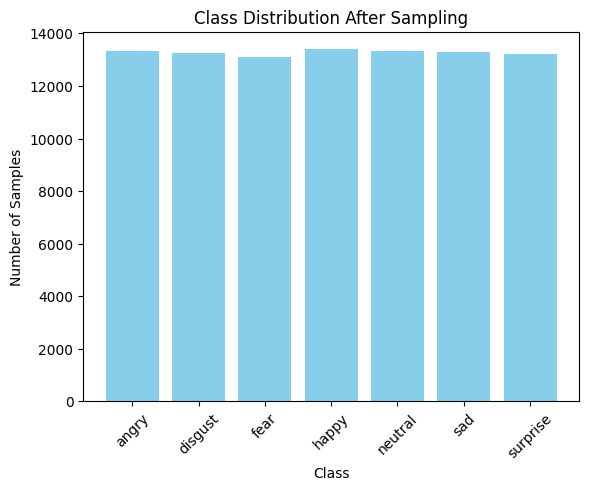

In [ ]:
from collections import Counter

sampled_indices = list(sampler)

sampled_labels = [train_emotion.targets[idx] for idx in sampled_indices]

sampled_class_counts = Counter(sampled_labels)

print("Class distribution after sampling:")
for class_idx, count in sampled_class_counts.items():
    print(f"{train_emotion.classes[class_idx]}: {count} samples")

import matplotlib.pyplot as plt

classes = [train_emotion.classes[idx] for idx in range(len(train_emotion.classes))]
class_sizes = [sampled_class_counts.get(idx, 0) for idx in range(len(train_emotion.classes))]

plt.bar(classes, class_sizes, color='skyblue')
plt.title("Class Distribution After Sampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)

train_loader_emotion = DataLoader(train_emotion, batch_size=128, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=128, shuffle=False)

class_names = train_emotion.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
def test(model, train_loader, test_loader):
    model.eval()
    predict_train = []
    predict_test = []
    labels_train = []
    labels_test = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())
    print("Confusion matrix on train:\n",
          confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names))))
    print("\nClassification report on train:\n",
          classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names)), target_names=class_names))
    print("\nConfusion matrix on test:\n",
          confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names))))
    print("\nClassification report on test:\n",
          classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names)), target_names=class_names))



Training the best model...
Epoch 0, Training loss 1.5167879876277142
Epoch 1, Training loss 1.4042847448398847
Epoch 2, Training loss 1.3276068454267562
Epoch 3, Training loss 1.2844326624024194
Epoch 4, Training loss 1.257581303995282
Evaluating the model...

Confusion Matrix (Train):
[[  735     0   555   853  3031   764   628]
 [   74     0    83   421  2304   183   166]
 [  250     0  1113   438  1556   586   916]
 [  212     0   351 19339  7217   890   583]
 [  221     0   391  2493 24293  1162   824]
 [  216     0   602  1424  7140  2327   514]
 [   80     0   408   719  2809   285  3812]]


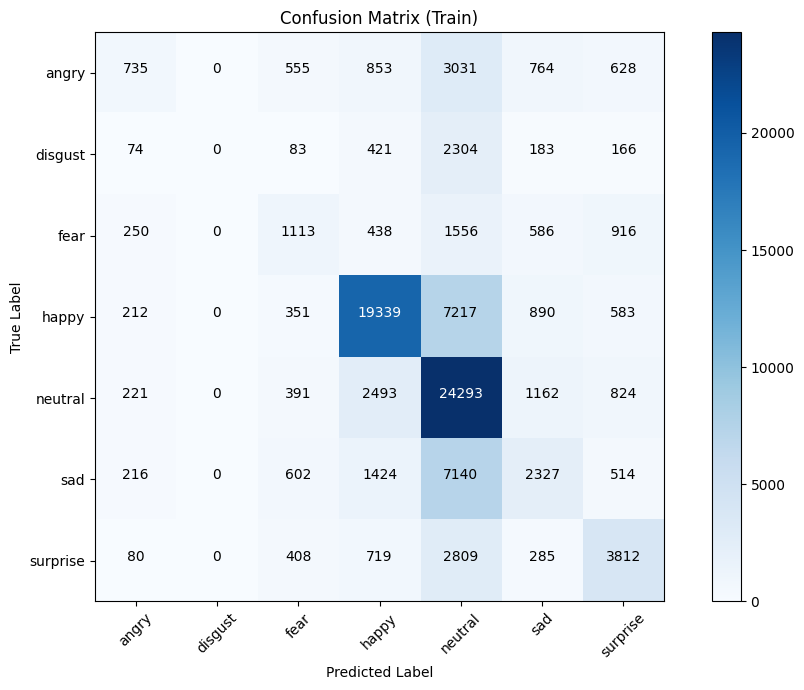


Confusion Matrix (Test):
[[ 112    0   85  170  425  117  132]
 [  22    0   12   86  456   39   40]
 [  30    0  121   70  225   91  154]
 [  45    0   74 1917 3018  256  149]
 [  50    0   62  446 4871  236  193]
 [  41    0   83  257 1275  327  194]
 [  29    0   54  119  623   57  593]]


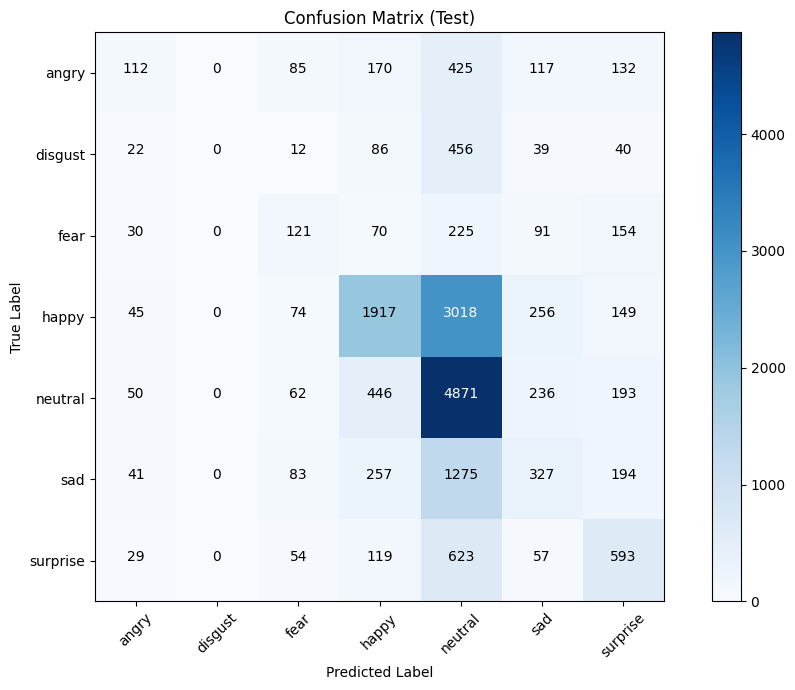


Classification Report (Train):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

       angry       0.41      0.11      0.18      6566
     disgust       0.00      0.00      0.00      3231
        fear       0.32      0.23      0.27      4859
       happy       0.75      0.68      0.71     28592
     neutral       0.50      0.83      0.63     29384
         sad       0.38      0.19      0.25     12223
    surprise       0.51      0.47      0.49      8113

    accuracy                           0.56     92968
   macro avg       0.41      0.36      0.36     92968
weighted avg       0.53      0.56      0.52     92968


Classification Report (Test):
              precision    recall  f1-score   support

       angry       0.34      0.11      0.16      1041
     disgust       0.00      0.00      0.00       655
        fear       0.25      0.18      0.20       691
       happy       0.63      0.35      0.45      5459
     neutral       0.45      0.83      0.58      5858
         sad       0.29      0.15      0.20    

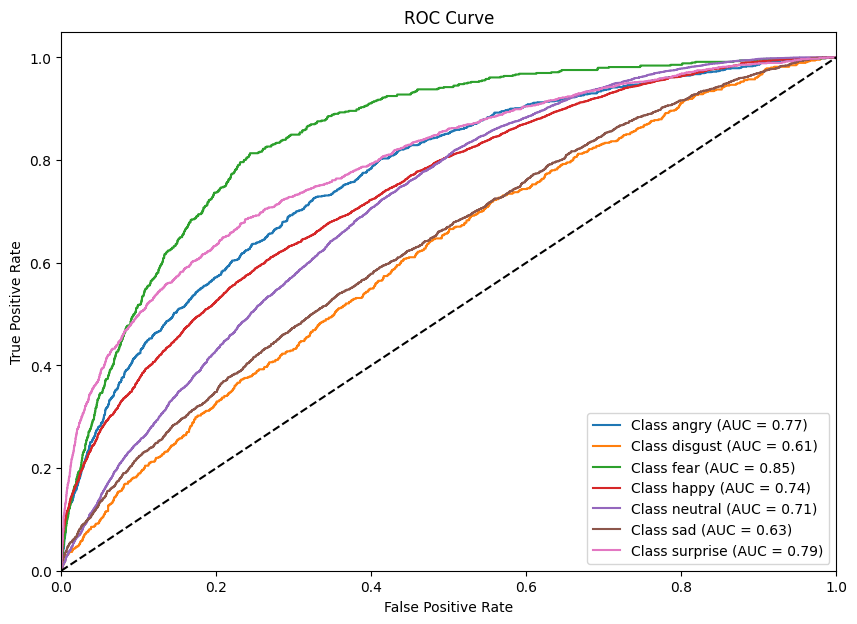

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import chain

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred_proba, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    plt.figure(figsize=(10, 7))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def evaluate_model(model, train_loader, test_loader, class_names):
    model.eval()

    predict_train = []
    labels_train = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predict_train.extend(predicted.tolist())
        labels_train.extend(labels.tolist())

    predict_test = []
    labels_test = []
    prob_test = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        predict_test.extend(predicted.tolist())
        labels_test.extend(labels.tolist())
        prob_test.extend(probs.tolist())

    cm_train = confusion_matrix(labels_train, predict_train)
    cm_test = confusion_matrix(labels_test, predict_test)

    print("\nConfusion Matrix (Train):")
    print(cm_train)
    plot_confusion_matrix(cm_train, class_names, title="Confusion Matrix (Train)")

    print("\nConfusion Matrix (Test):")
    print(cm_test)
    plot_confusion_matrix(cm_test, class_names, title="Confusion Matrix (Test)")

    print("\nClassification Report (Train):")
    print(classification_report(labels_train, predict_train, target_names=class_names))

    print("\nClassification Report (Test):")
    print(classification_report(labels_test, predict_test, target_names=class_names))

    print("\nROC Curve for Test:")
    plot_roc_curve(labels_test, np.array(prob_test), class_names)


torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("Training the best model...")
training_loop(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion
)

print("Evaluating the model...")
evaluate_model(model, train_loader_emotion, test_loader_emotion, class_names)


# Testing for diffrent epochs

In [ ]:
emotion_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])


train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=emotion_trans)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=emotion_trans)

train_loader_emotion = DataLoader(train_emotion, batch_size=128, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=128, shuffle=False)

class_names = train_emotion.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class neural_network(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 0 or epoch == n_epochs - 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))


In [ ]:
def test(model, train_loader, test_loader):
    model.eval()
    predict_train = []
    predict_test = []
    labels_train = []
    labels_test = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())
    print("Confusion matrix on train:\n",
          confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names))))
    print("\nClassification report on train:\n",
          classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=range(len(class_names)), target_names=class_names))
    print("\nConfusion matrix on test:\n",
          confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names))))
    print("\nClassification report on test:\n",
          classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=range(len(class_names)), target_names=class_names))



Training the best model...
Epoch 0, Training loss 1.5167879876277142
Epoch 1, Training loss 1.4042847448398847
Epoch 2, Training loss 1.3276068454267562
Epoch 3, Training loss 1.2844326624024194
Epoch 4, Training loss 1.257581303995282
Epoch 5, Training loss 1.2386696847793652
Epoch 6, Training loss 1.22368266862885
Epoch 7, Training loss 1.2116805148583822
Epoch 8, Training loss 1.201829415895916
Epoch 9, Training loss 1.1921649034938262
Evaluating the model...

Confusion Matrix (Train):
[[ 1361     0   175  1453  2834   382   361]
 [  152     1    31   692  2149   114    92]
 [  577     0   658   859  1629   391   745]
 [  239     0    78 22978  4698   336   263]
 [  443     0   121  4437 23315   666   402]
 [  534     0   218  2483  6892  1830   266]
 [  240     0   161  1275  2700   201  3536]]


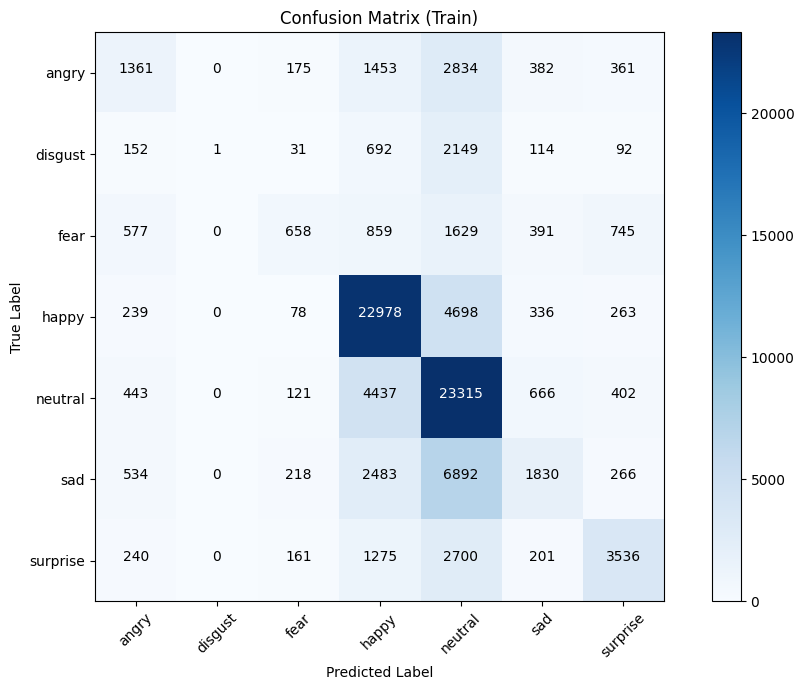


Confusion Matrix (Test):
[[ 207    0   20  277  379   74   84]
 [  42    0    5  129  428   28   23]
 [  69    0   60  128  232   79  123]
 [  76    0   21 2638 2514  125   85]
 [ 102    0   17  867 4614  147  111]
 [ 101    0   24  471 1220  240  121]
 [  62    0   35  218  621   37  502]]


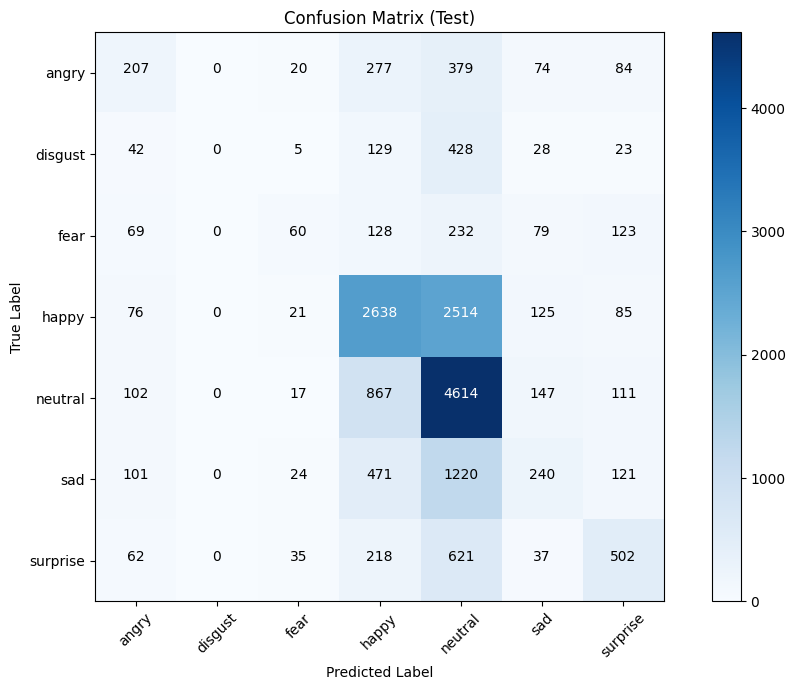


Classification Report (Train):
              precision    recall  f1-score   support

       angry       0.38      0.21      0.27      6566
     disgust       1.00      0.00      0.00      3231
        fear       0.46      0.14      0.21      4859
       happy       0.67      0.80      0.73     28592
     neutral       0.53      0.79      0.63     29384
         sad       0.47      0.15      0.23     12223
    surprise       0.62      0.44      0.51      8113

    accuracy                           0.58     92968
   macro avg       0.59      0.36      0.37     92968
weighted avg       0.57      0.58      0.53     92968


Classification Report (Test):
              precision    recall  f1-score   support

       angry       0.31      0.20      0.24      1041
     disgust       0.00      0.00      0.00       655
        fear       0.33      0.09      0.14       691
       happy       0.56      0.48      0.52      5459
     neutral       0.46      0.79      0.58      5858
         sad   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


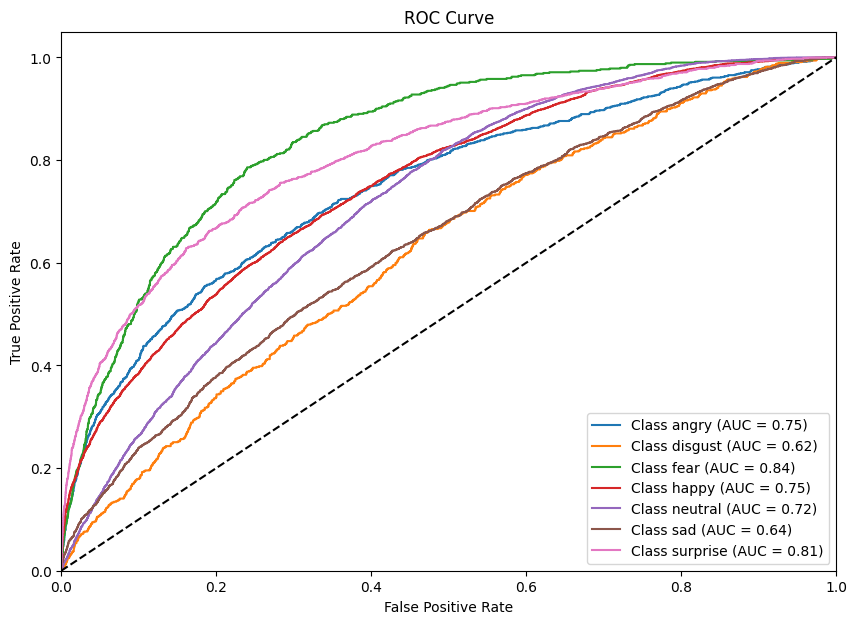

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import chain

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred_proba, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    plt.figure(figsize=(10, 7))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def evaluate_model(model, train_loader, test_loader, class_names):
    model.eval()

    predict_train = []
    labels_train = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predict_train.extend(predicted.tolist())
        labels_train.extend(labels.tolist())

    predict_test = []
    labels_test = []
    prob_test = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        predict_test.extend(predicted.tolist())
        labels_test.extend(labels.tolist())
        prob_test.extend(probs.tolist())

    cm_train = confusion_matrix(labels_train, predict_train)
    cm_test = confusion_matrix(labels_test, predict_test)

    print("\nConfusion Matrix (Train):")
    print(cm_train)
    plot_confusion_matrix(cm_train, class_names, title="Confusion Matrix (Train)")

    print("\nConfusion Matrix (Test):")
    print(cm_test)
    plot_confusion_matrix(cm_test, class_names, title="Confusion Matrix (Test)")

    print("\nClassification Report (Train):")
    print(classification_report(labels_train, predict_train, target_names=class_names))

    print("\nClassification Report (Test):")
    print(classification_report(labels_test, predict_test, target_names=class_names))

    print("\nROC Curve for Test:")
    plot_roc_curve(labels_test, np.array(prob_test), class_names)


torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("Training the best model...")
training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion
)

print("Evaluating the model...")
evaluate_model(model, train_loader_emotion, test_loader_emotion, class_names)


In [ ]:
#adbonded cell
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import chain

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred_proba, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    plt.figure(figsize=(10, 7))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def evaluate_model(model, train_loader, test_loader, class_names):
    model.eval()

    predict_train = []
    labels_train = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predict_train.extend(predicted.tolist())
        labels_train.extend(labels.tolist())

    predict_test = []
    labels_test = []
    prob_test = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        predict_test.extend(predicted.tolist())
        labels_test.extend(labels.tolist())
        prob_test.extend(probs.tolist())

    cm_train = confusion_matrix(labels_train, predict_train)
    cm_test = confusion_matrix(labels_test, predict_test)

    print("\nConfusion Matrix (Train):")
    print(cm_train)
    plot_confusion_matrix(cm_train, class_names, title="Confusion Matrix (Train)")

    print("\nConfusion Matrix (Test):")
    print(cm_test)
    plot_confusion_matrix(cm_test, class_names, title="Confusion Matrix (Test)")

    print("\nClassification Report (Train):")
    print(classification_report(labels_train, predict_train, target_names=class_names))

    print("\nClassification Report (Test):")
    print(classification_report(labels_test, predict_test, target_names=class_names))

    print("\nROC Curve for Test:")
    plot_roc_curve(labels_test, np.array(prob_test), class_names)


torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("Training the best model...")
training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion
)

print("Evaluating the model...")
evaluate_model(model, train_loader_emotion, test_loader_emotion, class_names)


Training the best model...
Epoch 0, Training loss 1.5167879876277142
Epoch 1, Training loss 1.4042847448398847
Epoch 2, Training loss 1.3276068454267562
Epoch 3, Training loss 1.2844326624024194
Epoch 4, Training loss 1.257581303995282
Epoch 5, Training loss 1.2386696847793652
Epoch 6, Training loss 1.22368266862885
Epoch 7, Training loss 1.2116805148583822
Epoch 8, Training loss 1.201829415895916
Epoch 9, Training loss 1.1921649034938262
Epoch 10, Training loss 1.1850264330677678
Epoch 11, Training loss 1.1766529290679397
Epoch 12, Training loss 1.1707594861190618
Epoch 13, Training loss 1.167813334865124


# Testing for different epochs

Training the best model...
Epoch 0, Training loss 1.5167879876277142
Epoch 1, Training loss 1.4042847448398847
Epoch 2, Training loss 1.3276068454267562
Epoch 3, Training loss 1.2844326624024194
Epoch 4, Training loss 1.257581303995282
Epoch 5, Training loss 1.2386696847793652
Epoch 6, Training loss 1.22368266862885
Epoch 7, Training loss 1.2116805148583822
Epoch 8, Training loss 1.201829415895916
Epoch 9, Training loss 1.1921649034938262
Epoch 10, Training loss 1.1850264330677678
Epoch 11, Training loss 1.1766529290679397
Epoch 12, Training loss 1.1707594861190618
Epoch 13, Training loss 1.167813334865124
Epoch 14, Training loss 1.1630351660668112
Evaluating the model...

Confusion Matrix (Train):
[[ 1553     0   332   852  2516   812   501]
 [  184     0    65   428  2146   256   152]
 [  558     0  1079   452  1240   710   820]
 [  323     0   173 21682  5152   831   431]
 [  486     0   259  2804 23579  1620   636]
 [  517     0   408  1459  6249  3215   375]
 [  213     0   256   

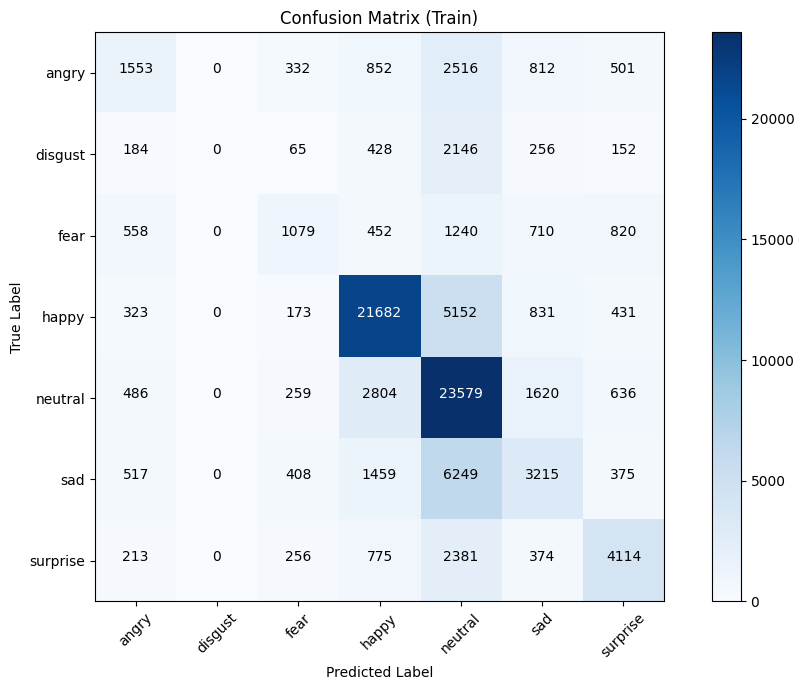


Confusion Matrix (Test):
[[ 242    0   45  182  331  127  114]
 [  46    0    5   77  420   65   42]
 [  71    0  101   70  212  105  132]
 [  94    0   40 2185 2644  332  164]
 [ 111    0   45  535 4605  351  211]
 [  93    0   48  299 1173  397  167]
 [  52    0   50  123  579   79  592]]


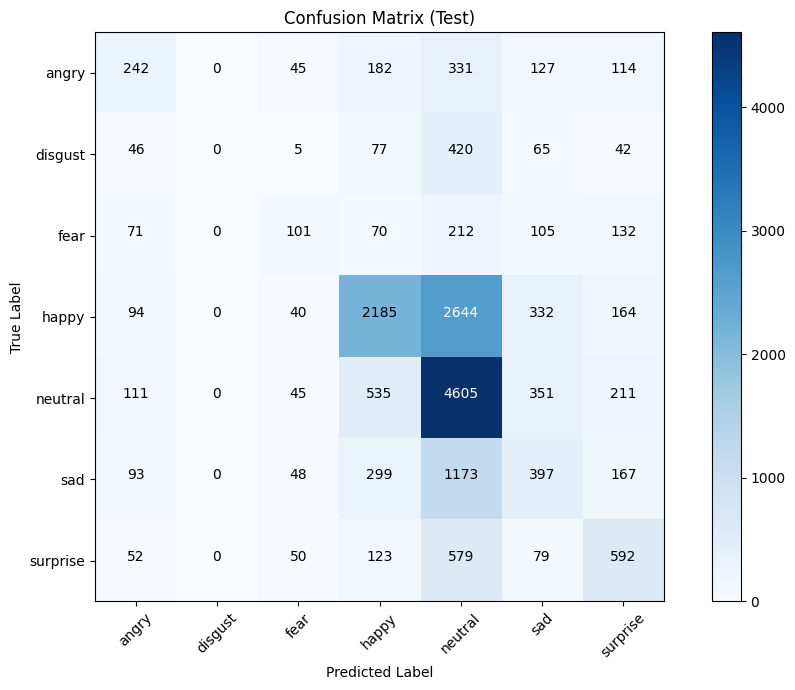


Classification Report (Train):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

       angry       0.41      0.24      0.30      6566
     disgust       0.00      0.00      0.00      3231
        fear       0.42      0.22      0.29      4859
       happy       0.76      0.76      0.76     28592
     neutral       0.55      0.80      0.65     29384
         sad       0.41      0.26      0.32     12223
    surprise       0.59      0.51      0.54      8113

    accuracy                           0.59     92968
   macro avg       0.45      0.40      0.41     92968
weighted avg       0.56      0.59      0.56     92968


Classification Report (Test):
              precision    recall  f1-score   support

       angry       0.34      0.23      0.28      1041
     disgust       0.00      0.00      0.00       655
        fear       0.30      0.15      0.20       691
       happy       0.63      0.40      0.49      5459
     neutral       0.46      0.79      0.58      5858
         sad       0.27      0.18      0.22    

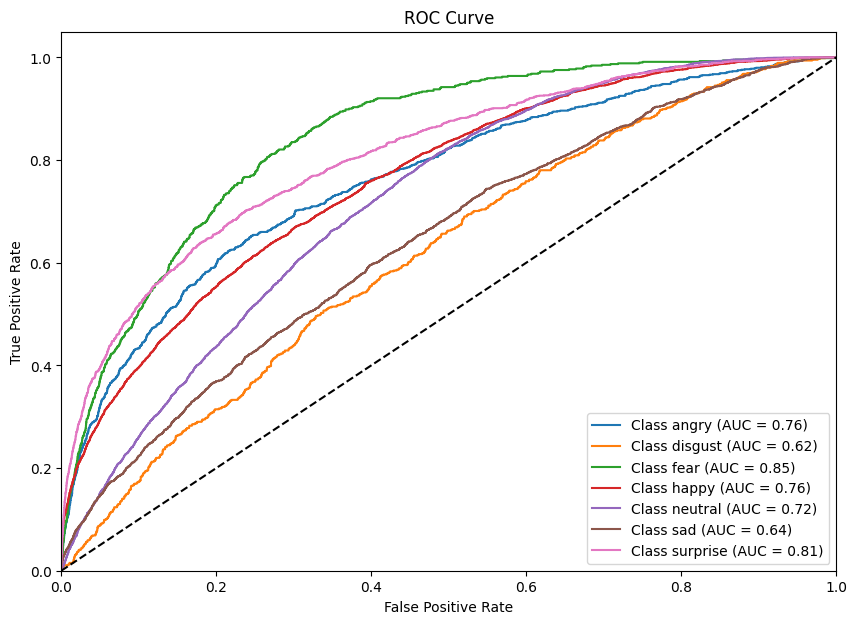

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import chain

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_pred_proba, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    plt.figure(figsize=(10, 7))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def evaluate_model(model, train_loader, test_loader, class_names):
    model.eval()

    predict_train = []
    labels_train = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predict_train.extend(predicted.tolist())
        labels_train.extend(labels.tolist())

    predict_test = []
    labels_test = []
    prob_test = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        predict_test.extend(predicted.tolist())
        labels_test.extend(labels.tolist())
        prob_test.extend(probs.tolist())

    cm_train = confusion_matrix(labels_train, predict_train)
    cm_test = confusion_matrix(labels_test, predict_test)

    print("\nConfusion Matrix (Train):")
    print(cm_train)
    plot_confusion_matrix(cm_train, class_names, title="Confusion Matrix (Train)")

    print("\nConfusion Matrix (Test):")
    print(cm_test)
    plot_confusion_matrix(cm_test, class_names, title="Confusion Matrix (Test)")

    print("\nClassification Report (Train):")
    print(classification_report(labels_train, predict_train, target_names=class_names))

    print("\nClassification Report (Test):")
    print(classification_report(labels_test, predict_test, target_names=class_names))

    print("\nROC Curve for Test:")
    plot_roc_curve(labels_test, np.array(prob_test), class_names)


torch.manual_seed(0)
model = neural_network(32, len(class_names))
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

print("Training the best model...")
training_loop(
    n_epochs=15,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader_emotion
)

print("Evaluating the model...")
evaluate_model(model, train_loader_emotion, test_loader_emotion, class_names)


as the number of epochs are increasing accuracy is increasing

# testing only for one class to see if there is increase in accuracy

Epoch 1/5, Training Loss: 1.4573
Epoch 2/5, Training Loss: 1.3444
Epoch 3/5, Training Loss: 1.2995
Epoch 4/5, Training Loss: 1.2719
Epoch 5/5, Training Loss: 1.2514
Evaluating Class: angry

Confusion Matrix (Train):
[[ 1548     0   236   951  2625   635   571]
 [  192     0    33   460  2189   197   160]
 [  740     0   516   625  1361   480  1137]
 [  409     0   113 20205  6660   642   563]
 [  806     0   210  3214 23062  1171   921]
 [  860     0   244  1735  6666  2071   647]
 [  228     0   161   766  2571   284  4103]]

Confusion Matrix (Test):
[[ 224    0   35  187  375   90  130]
 [  39    0    4   71  456   42   43]
 [  88    0   43  100  200   93  167]
 [ 102    0   29 2010 2917  252  149]
 [ 158    0   20  565 4591  273  251]
 [ 145    0   26  309 1199  285  213]
 [  60    0   33  142  584   57  599]]

ROC Curve:


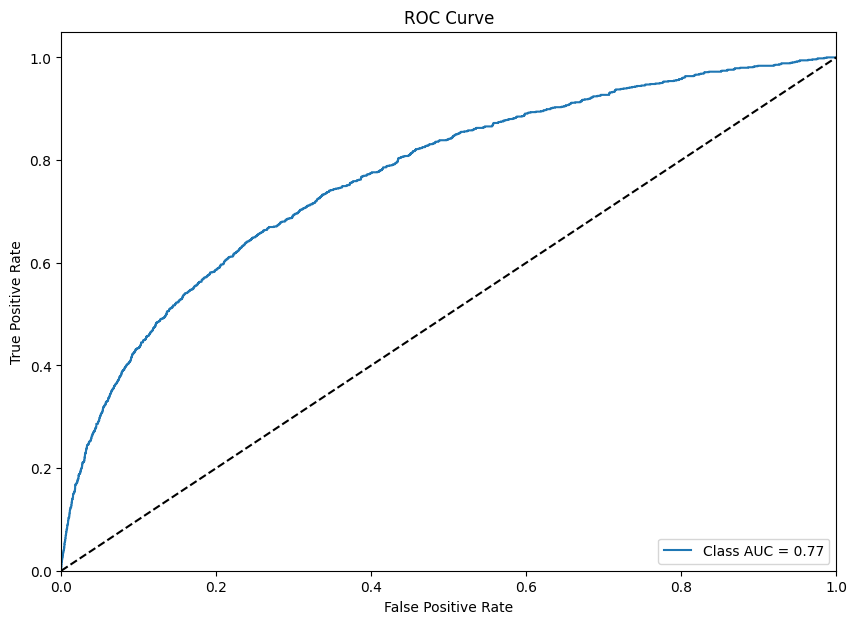

In [ ]:
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from collections import Counter
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Updated Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size1, out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(784, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, out_size)
        )

    def forward(self, x):
        return self.network(x)

# Plotting functions
def plot_roc_curve(y_true, y_pred_proba, classes):
    y_true_bin = label_binarize(y_true, classes=range(len(classes)))

    plt.figure(figsize=(10, 7))
    fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class AUC = {roc_auc:.2f}")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    train_losses = []
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        avg_loss = loss_train / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_loss:.4f}")
    return train_losses

# Testing function for a single class
def test_single_class(model, loader, class_idx):
    model.eval()
    predict = []
    labels = []
    prob_all = []
    with torch.no_grad():
        for inputs, label in loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            prob_all.extend(probs[:, class_idx].tolist())
            _, predicted = torch.max(outputs, dim=1)
            predict.extend(predicted.tolist())
            labels.extend(label.tolist())
    return labels, predict, prob_all

# Evaluate model with ROC curve and loss
def evaluate_single_class(model, train_loader, test_loader, class_names, class_idx):
    print(f"Evaluating Class: {class_names[class_idx]}")

    # Evaluate on Train Data
    labels_train, predict_train, prob_train = test_single_class(model, train_loader, class_idx)
    cm_train = confusion_matrix(labels_train, predict_train, labels=range(len(class_names)))
    print("\nConfusion Matrix (Train):")
    print(cm_train)

    # Evaluate on Test Data
    labels_test, predict_test, prob_test = test_single_class(model, test_loader, class_idx)
    cm_test = confusion_matrix(labels_test, predict_test, labels=range(len(class_names)))
    print("\nConfusion Matrix (Test):")
    print(cm_test)

    # Plot ROC Curve
    print("\nROC Curve:")
    plot_roc_curve(labels_test, np.array(prob_test), [class_names[class_idx]])

# Prepare dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4630, 0.4530, 0.3405], std=[0.2862, 0.2758, 0.2845])
])

train_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/train', transform=transform)
test_emotion = ImageFolder('/content/mma_facial_expression/MMAFEDB/test', transform=transform)

train_loader_emotion = DataLoader(train_emotion, batch_size=32, shuffle=True)
test_loader_emotion = DataLoader(test_emotion, batch_size=32, shuffle=False)

class_names = train_emotion.classes

# Initialize model
model = NeuralNetwork(32, len(class_names))
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train model
train_losses = training_loop(5, optimizer, model, loss_fn, train_loader_emotion)

# Evaluate for a single class
single_class_index = 0  # Example: Test for the first class
evaluate_single_class(model, train_loader_emotion, test_loader_emotion, class_names, single_class_index)
